# Step 1: Install Prophet

In [36]:
!pip install prophet --quiet

#Step 2: Import libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Step 3: Load dataset

In [38]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("Miles_Traveled.csv")

Saving Miles_Traveled.csv to Miles_Traveled (3).csv


# Step 4: Explore dataset

In [39]:
print(df.head())
print(df.info())

         DATE  TRFVOLUSM227NFWA
0  1970-01-01           80173.0
1  1970-02-01           77442.0
2  1970-03-01           90223.0
3  1970-04-01           89956.0
4  1970-05-01           97972.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              588 non-null    object 
 1   TRFVOLUSM227NFWA  588 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB
None


# Step 5: Preprocess data

In [40]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df = df.asfreq('MS')

# Step 6: Plot original time series

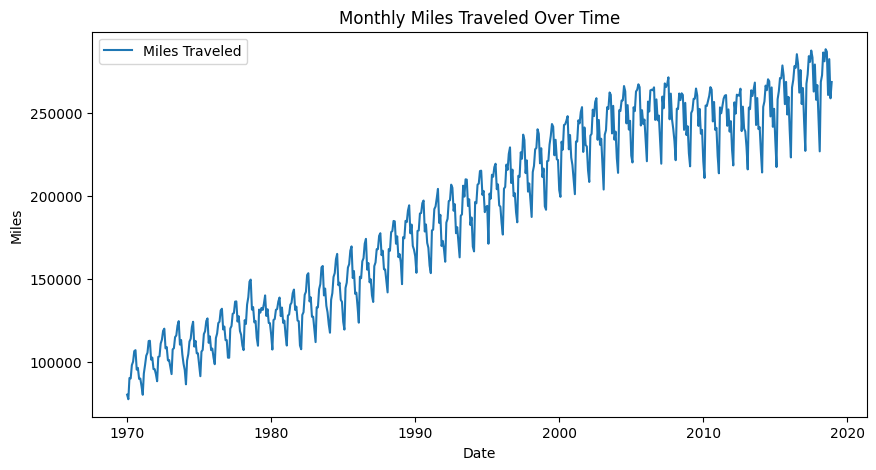

In [41]:
plt.figure(figsize=(10,5))
plt.plot(df.index, df['TRFVOLUSM227NFWA'], label='Miles Traveled')
plt.title("Monthly Miles Traveled Over Time")
plt.xlabel("Date")
plt.ylabel("Miles")
plt.legend()
plt.show()

# Step 7: Train-Test Split

In [42]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

#ARIMA MODEL

In [43]:
arima_model = ARIMA(train['TRFVOLUSM227NFWA'], order=(5,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))


# Evaluation

In [44]:
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)
print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"ARIMA MAE: {arima_mae:.2f}")

ARIMA RMSE: 39593.70
ARIMA MAE: 35859.30


 # Plot ARIMA results

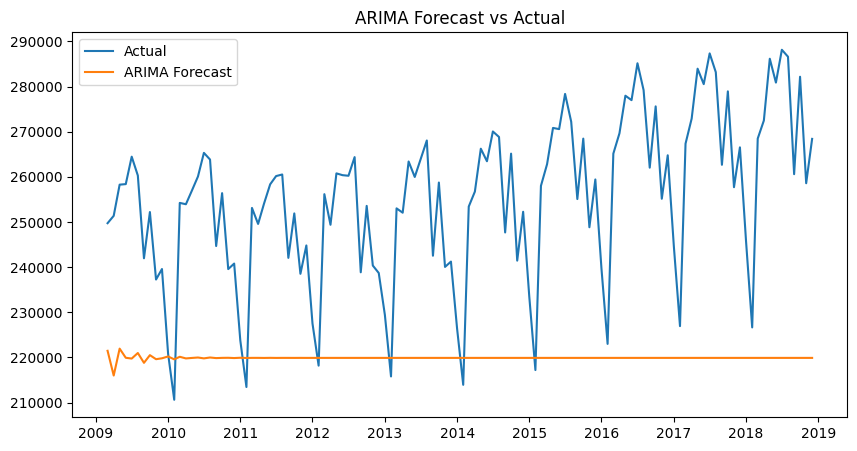

In [45]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test['TRFVOLUSM227NFWA'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()

#PROPHET MODEL

In [46]:
prophet_df = df.reset_index().rename(columns={'DATE':'ds', 'TRFVOLUSM227NFWA':'y'})
train_p = prophet_df.iloc[:train_size]
test_p = prophet_df.iloc[train_size:]

prophet_model = Prophet()
prophet_model.fit(train_p)

future = prophet_model.make_future_dataframe(periods=len(test_p), freq='MS')
forecast_p = prophet_model.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg5t_klou/w01akozr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg5t_klou/x0c4mtzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6485', 'data', 'file=/tmp/tmpg5t_klou/w01akozr.json', 'init=/tmp/tmpg5t_klou/x0c4mtzj.json', 'output', 'file=/tmp/tmpg5t_klou/prophet_modelml50xl4c/prophet_model-20250811062250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:22:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Evaluation

In [47]:
forecast_values_p = forecast_p['yhat'].iloc[-len(test_p):]
prophet_rmse = np.sqrt(mean_squared_error(test_p['y'], forecast_values_p))
prophet_mae = mean_absolute_error(test_p['y'], forecast_values_p)
print(f"Prophet RMSE: {prophet_rmse:.2f}")
print(f"Prophet MAE: {prophet_mae:.2f}")

Prophet RMSE: 14890.62
Prophet MAE: 13531.16


# Plot Prophet results

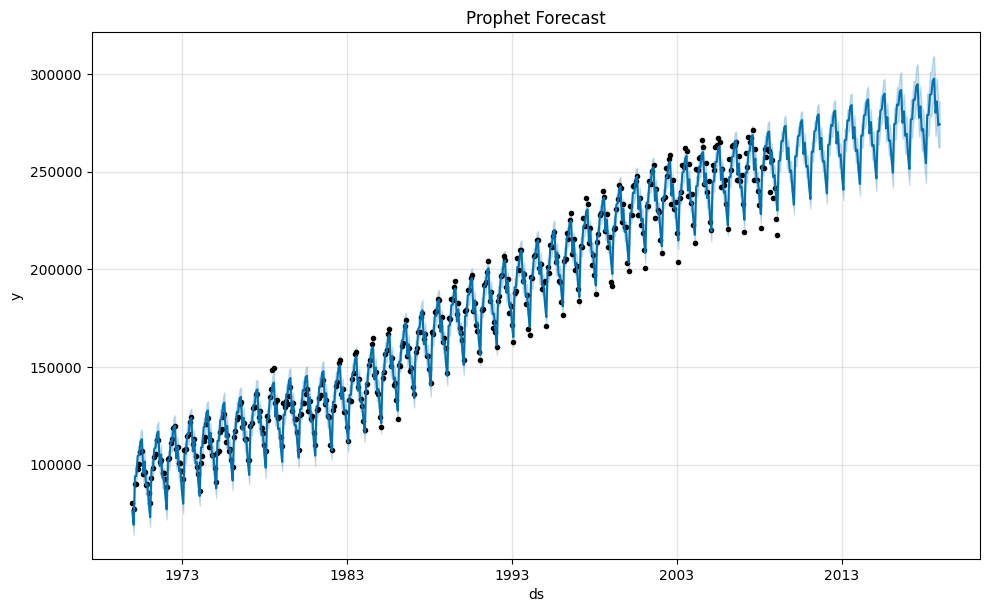

In [48]:
prophet_model.plot(forecast_p)
plt.title("Prophet Forecast")
plt.show()

#Final Summary

In [49]:
print("\nModel Performance Summary")
print(f"ARIMA -> RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")
print(f"Prophet -> RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}")


Model Performance Summary
ARIMA -> RMSE: 39593.70, MAE: 35859.30
Prophet -> RMSE: 14890.62, MAE: 13531.16


In [50]:
# Compare RMSE values
if arima_rmse < prophet_rmse:
    print(f"ARIMA performed better with RMSE = {arima_rmse:.2f} (vs Prophet RMSE = {prophet_rmse:.2f})")
else:
    print(f"Prophet performed better with RMSE = {prophet_rmse:.2f} (vs ARIMA RMSE = {arima_rmse:.2f})")


Prophet performed better with RMSE = 14890.62 (vs ARIMA RMSE = 39593.70)
